
# CTR EDA (Polars-First, LGBM-Compatible)
- 목적: 최신 코드(lgbm_2)와 **맥락을 공유**하는 EDA 노트북. 메모리 안정성(Polars Lazy), 빠른 탐색, 재현성을 최우선.
- 데이터 경로는 기존과 동일하게 사용합니다: `../data/train.parquet`, `../data/test.parquet`, `../data/sample_submission.csv`
- 산출물: 스키마/결측/조건부 CTR/시퀀스 요약, Train–Test 분포차 및 경량 Adversarial Validation AUC

**주의**: 이 노트북은 표 중심으로 설계되어 차트 의존도를 낮춥니다. 대용량 수행 시 항상 `streaming=True` 또는 샘플링을 병행하세요.


In [1]:

# 0) Setup
import os, gc, time, math, json, random
import numpy as np
import polars as pl

# 경량 모델링/검증용
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import lightgbm as lgb

# 재현성
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

pl.Config.set_tbl_rows(30)
pl.Config.set_fmt_str_lengths(120)

DATA_DIR = "../data"
TRAIN_PATH = os.path.join(DATA_DIR, "../data/train.parquet")
TEST_PATH  = os.path.join(DATA_DIR, "../data/test.parquet")  # test에는 ID가 포함되어 있을 수 있음
SUB_PATH   = os.path.join(DATA_DIR, "../data/sample_submission.csv")

ARTIFACT_DIR = "./artifacts_eda"
os.makedirs(ARTIFACT_DIR, exist_ok=True)


/opt/conda/lib/python3.10/site-packages/cupy/_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:

# 1) Lazy Load & Minimal Columns
t0 = time.time()
train_lf = pl.scan_parquet(TRAIN_PATH)
test_lf  = pl.scan_parquet(TEST_PATH)

# 주요 컬럼 초기 세트 (존재하면 선택): clicked/seq/inventory_id/hour/day_of_week/gender/age_group
INITIAL_COLS = [
    "clicked", "seq", "inventory_id", "hour", "day_of_week", "gender", "age_group"
]

# 실제 존재하는 컬럼만 선택
train_cols = [c for c in INITIAL_COLS if c in train_lf.collect_schema().names()]
test_cols  = [c for c in INITIAL_COLS if c in test_lf.collect_schema().names() and c != "clicked"]  # test에는 clicked 없음

train_sel = train_lf.select(train_cols)
test_sel  = test_lf.select(test_cols)

print("Selected (train):", train_cols)
print("Selected (test) :", test_cols)
print(f"Lazy setup done in {time.time()-t0:.2f}s")


Selected (train): ['clicked', 'seq', 'inventory_id', 'hour', 'day_of_week', 'gender', 'age_group']
Selected (test) : ['seq', 'inventory_id', 'hour', 'day_of_week', 'gender', 'age_group']
Lazy setup done in 0.02s


In [3]:

# 2) 기본 개요 및 스키마 비교
train_schema = train_lf.collect_schema()
test_schema  = test_lf.collect_schema()

print("Train columns:", len(train_schema))
print("Test  columns:", len(test_schema))

train_names = set(train_schema.names())
test_names  = set(test_schema.names())

only_in_train = sorted(list(train_names - test_names))
only_in_test  = sorted(list(test_names - train_names))
common_names  = sorted(list(train_names & test_names))

print("\n[Only in Train]", len(only_in_train), only_in_train[:20])
print("[Only in Test ]", len(only_in_test ), only_in_test[:20])
print("[Common       ]", len(common_names))

# dtype 요약 (상위 50개만 보기)
def dtype_dict(schema):
    d = {}
    for n, dt in zip(schema.names(), schema.dtypes()):
        d.setdefault(str(dt), []).append(n)
    return {k: len(v) for k, v in d.items()}

print("\nDtypes (Train):", dtype_dict(train_schema))
print("Dtypes (Test) :", dtype_dict(test_schema))


Train columns: 119
Test  columns: 119

[Only in Train] 1 ['clicked']
[Only in Test ] 1 ['ID']
[Common       ] 118

Dtypes (Train): {'String': 6, 'Float32': 112, 'Int32': 1}
Dtypes (Test) : {'String': 7, 'Float32': 112}


In [4]:

# 3) 라벨 분포 (clicked 비율)
if "clicked" in train_cols:
    lbl = train_sel.select(
        pl.col("clicked").mean().alias("ctr_mean"),
        pl.len().alias("n_rows"),
        (pl.col("clicked")==1).sum().alias("pos_cnt"),
        (pl.col("clicked")==0).sum().alias("neg_cnt"),
    ).collect(streaming=True)
    print(lbl)
else:
    print("clicked 라벨이 선택되지 않았습니다. (스키마 확인 필요)")


shape: (1, 4)
┌──────────┬──────────┬─────────┬──────────┐
│ ctr_mean ┆ n_rows   ┆ pos_cnt ┆ neg_cnt  │
│ ---      ┆ ---      ┆ ---     ┆ ---      │
│ f64      ┆ u32      ┆ u32     ┆ u32      │
╞══════════╪══════════╪═════════╪══════════╡
│ 0.019075 ┆ 10704179 ┆ 204179  ┆ 10500000 │
└──────────┴──────────┴─────────┴──────────┘


/tmp/ipykernel_226933/3006013180.py:3: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  lbl = train_sel.select(


In [ ]:
# 4) 결측 집계 (열/행) — LazyFrame 안전 버전

# 열 단위 결측율 Top-N (변경 없음)
def null_ratio_table(lf: pl.LazyFrame, topn: int = 30) -> pl.DataFrame:
    exprs = []
    for c in lf.collect_schema().names():
        exprs.append((pl.col(c).is_null().cast(pl.UInt32).sum()/pl.len()).alias(c))
    out = lf.select(exprs).collect(streaming=True).transpose(include_header=True, header_name="column", column_names=["null_ratio"])
    return out.sort("null_ratio", descending=True).head(topn)

train_null_top = null_ratio_table(train_lf, topn=50)
test_null_top  = null_ratio_table(test_lf,  topn=50)

print("\n[Train: null ratio top]")
print(train_null_top)
print("\n[Test : null ratio top]")
print(test_null_top)

# 모든 컬럼에 대해 null→1, not null→0로 바꿔서 행별 합계 계산
row_nulls_hist = (
    train_lf
    .select(pl.sum_horizontal(*[pl.col(c).is_null().cast(pl.UInt16) for c in train_lf.collect_schema().names()]).alias("row_nulls"))
    .group_by("row_nulls").len().sort("row_nulls")
    .collect(streaming=True)
)

print("\n[Row nulls histogram - train (streaming, fold)]")
print(row_nulls_hist)


/tmp/ipykernel_226933/3252235930.py:8: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  out = lf.select(exprs).collect(streaming=True).transpose(include_header=True, header_name="column", column_names=["null_ratio"])



[Train: null ratio top]
shape: (50, 2)
┌───────────┬────────────┐
│ column    ┆ null_ratio │
│ ---       ┆ ---        │
│ str       ┆ f64        │
╞═══════════╪════════════╡
│ feat_e_3  ┆ 0.101414   │
│ feat_a_1  ┆ 0.001737   │
│ feat_a_2  ┆ 0.001737   │
│ feat_a_3  ┆ 0.001737   │
│ feat_a_4  ┆ 0.001737   │
│ feat_a_5  ┆ 0.001737   │
│ feat_a_6  ┆ 0.001737   │
│ feat_a_7  ┆ 0.001737   │
│ feat_a_8  ┆ 0.001737   │
│ feat_a_9  ┆ 0.001737   │
│ feat_a_10 ┆ 0.001737   │
│ feat_a_11 ┆ 0.001737   │
│ feat_a_12 ┆ 0.001737   │
│ feat_a_13 ┆ 0.001737   │
│ feat_a_14 ┆ 0.001737   │
│ …         ┆ …          │
│ feat_e_7  ┆ 0.001608   │
│ feat_e_8  ┆ 0.001608   │
│ feat_e_9  ┆ 0.001608   │
│ feat_e_10 ┆ 0.001608   │
│ feat_d_1  ┆ 0.001608   │
│ feat_d_2  ┆ 0.001608   │
│ feat_d_3  ┆ 0.001608   │
│ feat_d_4  ┆ 0.001608   │
│ feat_d_5  ┆ 0.001608   │
│ feat_d_6  ┆ 0.001608   │
│ feat_c_1  ┆ 0.001608   │
│ feat_c_2  ┆ 0.001608   │
│ feat_c_3  ┆ 0.001608   │
│ feat_c_4  ┆ 0.001608   │
│ feat_c_5  ┆ 0

/tmp/ipykernel_226933/3252235930.py:21: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  train_lf



[Row nulls histogram - train (streaming, fold)]
shape: (6, 2)
┌───────────┬─────────┐
│ row_nulls ┆ len     │
│ ---       ┆ ---     │
│ u16       ┆ u32     │
╞═══════════╪═════════╡
│ 0         ┆ 9611653 │
│ 1         ┆ 1073928 │
│ 18        ┆ 1206    │
│ 19        ┆ 184     │
│ 95        ┆ 5763    │
│ 96        ┆ 11445   │
└───────────┴─────────┘



[CTR by seq_len_decile]
shape: (10, 3)
┌────────────────────────────────┬─────────┬──────────┐
│ seq_len_decile                 ┆ n       ┆ ctr      │
│ ---                            ┆ ---     ┆ ---      │
│ cat                            ┆ u32     ┆ f64      │
╞════════════════════════════════╪═════════╪══════════╡
│ [1, 60.00000001)               ┆ 1078590 ┆ 0.03239  │
│ [439.00000005, 561.00000006)   ┆ 1076874 ┆ 0.016798 │
│ [138.00000002, 229.00000003)   ┆ 1072698 ┆ 0.019499 │
│ [871.00000008, 1124.00000009)  ┆ 1072415 ┆ 0.01581  │
│ [60.00000001, 138.00000002)    ┆ 1070280 ┆ 0.022329 │
│ [561.00000006, 699.00000007)   ┆ 1067750 ┆ 0.016039 │
│ [1124.00000009, 14441.0000001) ┆ 1067570 ┆ 0.016054 │
│ [229.00000003, 329.00000004)   ┆ 1066459 ┆ 0.018255 │
│ [699.00000007, 871.00000008)   ┆ 1065979 ┆ 0.015881 │
│ [329.00000004, 439.00000005)   ┆ 1065564 ┆ 0.017571 │
└────────────────────────────────┴─────────┴──────────┘


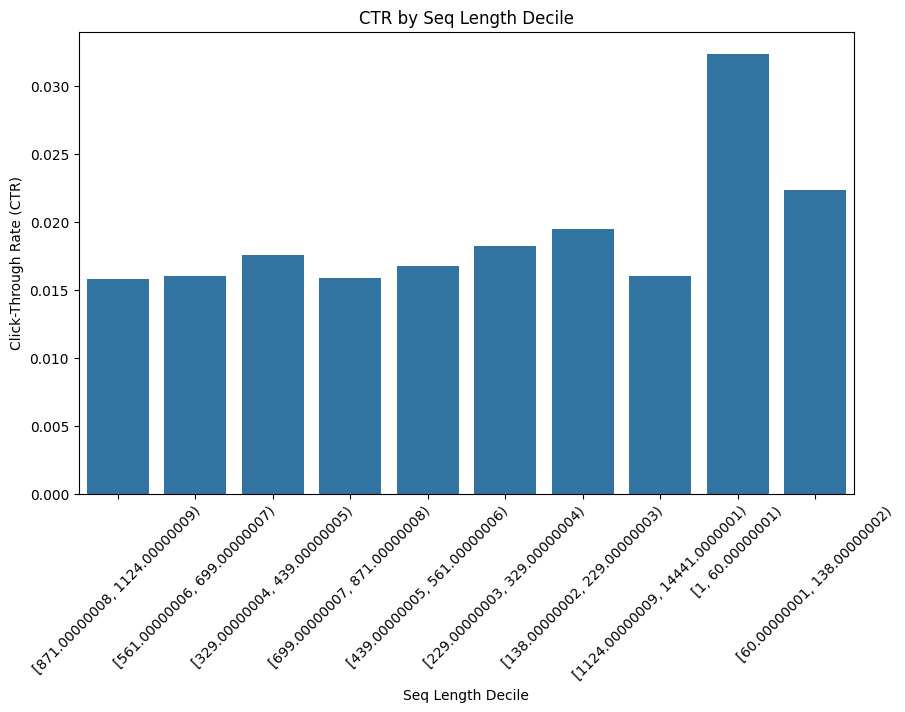

In [6]:
# seq_len 디사일 버킷: cut(breaks=...) 안정화 버전

if "seq" in train_cols:
    # 1) seq_len 계산
    train_seq = train_sel.with_columns([
        pl.when(pl.col("seq").is_null())
          .then(pl.lit(0))
          .otherwise(pl.col("seq").str.count_matches(",") + 1)
          .alias("seq_len")
    ])

    # 2) 분위수 계산(0.1~0.9)
    qs = [i/10 for i in range(1, 10)]
    quant_exprs = [pl.col("seq_len").quantile(q).alias(f"q{int(q*100)}") for q in qs]
    qtiles = train_seq.select(quant_exprs).collect()

    # 3) 유한 경계 구성: [min, q10..q90, max] + 중복/비단조 보정
    mm = train_seq.select([
        pl.col("seq_len").min().alias("min"),
        pl.col("seq_len").max().alias("max")
    ]).collect()
    min_v = float(mm[0, "min"])
    max_v = float(mm[0, "max"])
    edges = [min_v] + [float(qtiles[0, f"q{int(q*100)}"]) for q in qs] + [max_v]

    import numpy as np
    edges = np.array(edges, dtype=float)

    # 중복 제거 후 단조 증가 보정(동일 값이 있으면 소량의 epsilon 누적)
    edges = np.unique(edges)
    if len(edges) < 3:
        print("[WARN] 유효 경계가 부족해 디사일 버킷 생성을 스킵합니다.")
    else:
        # ensure strictly increasing: 누적 최대 + 작은 증가분
        eps = np.linspace(0.0, 1e-8*(len(edges)-1), len(edges))
        edges = np.maximum.accumulate(edges + eps).tolist()

        # 4) cut으로 버킷 생성(좌측 폐구간)
        train_seq_q = train_seq.with_columns(
            pl.col("seq_len").cut(breaks=edges, left_closed=True).alias("seq_len_decile")
        )

        # 5) 디사일별 CTR
        ctr_seq_dec = (
            train_seq_q
            .group_by("seq_len_decile")
            .agg([pl.len().alias("n"), pl.col("clicked").mean().alias("ctr")])
            .sort("n", descending=True)
            .collect()
        )
        print("\n[CTR by seq_len_decile]")
        print(ctr_seq_dec)
        # 6) 시각화
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.barplot(data=ctr_seq_dec.to_pandas(), x="seq_len_decile", y="ctr")
        plt.xticks(rotation=45)
        plt.title("CTR by Seq Length Decile")
        plt.xlabel("Seq Length Decile")
        plt.ylabel("Click-Through Rate (CTR)")
        plt.show()
else:
    print("seq 컬럼이 선택되지 않았습니다. (스키마 확인 필요)")


In [ ]:

# 6) Train–Test 분포 비교 (공통 컬럼 기준, 범주/수치 요약)
common = [c for c in train_schema.names() if c in test_schema.names()]
# 메모리 절약: 대표 컬럼만 추려서 비교
REP_COLS = [c for c in ["inventory_id", "hour", "day_of_week", "gender", "age_group", "seq"] if c in common]

def summarize_numeric(lf: pl.LazyFrame, col: str) -> pl.DataFrame:
    return lf.select([
        pl.col(col).min().alias("min"),
        pl.col(col).quantile(0.5).alias("p50"),
        pl.col(col).quantile(0.95).alias("p95"),
        pl.col(col).quantile(0.99).alias("p99"),
        pl.col(col).max().alias("max"),
        pl.len().alias("n"),
    ]).collect(streaming=True)

def topk_cats(lf: pl.LazyFrame, col: str, k: int = 20) -> pl.DataFrame:
    return lf.group_by(col).len().sort("len", descending=True).head(k).collect(streaming=True)

train_head = {}
test_head  = {}

for c in REP_COLS:
    if train_schema[c] in (pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16):
        train_head[c] = summarize_numeric(train_lf, c)
        test_head[c]  = summarize_numeric(test_lf, c)
    else:
        train_head[c] = topk_cats(train_lf, c, k=20)
        test_head[c]  = topk_cats(test_lf,  c, k=20)

print("\n[Train summary (rep cols)]");  [print(k, "\n", v) for k,v in train_head.items()]
print("\n[Test  summary (rep cols)]");  [print(k, "\n", v) for k,v in test_head.items()]


/tmp/ipykernel_226933/2553380213.py:17: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  return lf.group_by(col).len().sort("len", descending=True).head(k).collect(streaming=True)



[Train summary (rep cols)]
inventory_id 
 shape: (18, 2)
┌──────────────┬─────────┐
│ inventory_id ┆ len     │
│ ---          ┆ ---     │
│ str          ┆ u32     │
╞══════════════╪═════════╡
│ 2            ┆ 2630473 │
│ 36           ┆ 1518438 │
│ 37           ┆ 1396465 │
│ 29           ┆ 1015710 │
│ 42           ┆ 1013762 │
│ 46           ┆ 822847  │
│ 88           ┆ 668809  │
│ 43           ┆ 453255  │
│ 31           ┆ 434347  │
│ 11           ┆ 321821  │
│ 41           ┆ 236609  │
│ 91           ┆ 101032  │
│ 39           ┆ 34991   │
│ 19           ┆ 25746   │
│ 8            ┆ 21641   │
│ 95           ┆ 4903    │
│ 92           ┆ 2341    │
│ 21           ┆ 989     │
└──────────────┴─────────┘
hour 
 shape: (20, 2)
┌──────┬────────┐
│ hour ┆ len    │
│ ---  ┆ ---    │
│ str  ┆ u32    │
╞══════╪════════╡
│ 08   ┆ 755311 │
│ 12   ┆ 607775 │
│ 07   ┆ 603023 │
│ 09   ┆ 587434 │
│ 20   ┆ 584545 │
│ 10   ┆ 576432 │
│ 19   ┆ 569826 │
│ 21   ┆ 541590 │
│ 00   ┆ 536658 │
│ 11   ┆ 512721 │
│ 

[None, None, None, None, None, None]

In [8]:
# 7) Adversarial Validation (경량) — Lazy 친화 샘플링으로 수정

ADV_TARGET = 600_000        # 전체 합산 샘플 목표치 (train+test)
ADV_EACH   = ADV_TARGET // 2
HASH_BASE  = 10_000_000     # 모듈로 분모(충분히 큰 값)
SEED       = SEED           # 이미 위에서 정의됨

# 1) 사용할 컬럼 선별
NUMERICS = [n for n, dt in zip(train_schema.names(), train_schema.dtypes())
            if dt in (pl.Float32, pl.Float64, pl.Int16, pl.Int32, pl.Int64) and n != "clicked"]
CATS = [n for n, dt in zip(train_schema.names(), train_schema.dtypes())
        if dt in (pl.Categorical, pl.Utf8) and n in ["inventory_id","gender","age_group","day_of_week","hour","seq"]]
USE_COLS = list(set(NUMERICS[:30] + CATS))  # 과한 차원 방지

print("AdvVal USE_COLS:", USE_COLS[:20], "... total", len(USE_COLS))

# 2) LazyFrame에서 랜덤 대용: 여러 컬럼을 해시→모듈러로 필터
#    - 같은 규칙을 train/test 모두에 적용 → 분포 일관성
#    - 목표 샘플 수에 맞춰 threshold를 조정
def hash_subsample_lazy(lf: pl.LazyFrame, use_cols: list[str], target_n: int, seed: int) -> pl.DataFrame:
    cols = [c for c in use_cols if c in lf.collect_schema().names()]
    # 해시 입력이 하나도 없으면 임의로 hour/day_of_week 등 추가
    if not cols:
        fallback = [c for c in ["inventory_id","hour","day_of_week"] if c in lf.collect_schema().names()]
        cols = fallback or lf.collect_schema().names()[:3]

    # 대략적인 비율을 위해 threshold 산출(행수 추정)
    approx_rows = lf.select(pl.len()).collect().item()
    frac = min(1.0, max(0.0001, target_n / max(1, approx_rows)))
    threshold = int(frac * HASH_BASE)

    # 해시 계산 (seed 섞기): 여러 컬럼을 결합해 안정적/균질 분포 유도
    h = pl.concat_str([pl.col(c).cast(pl.Utf8) for c in cols], separator="|")
    h = (h + pl.lit(f"|{seed}")).hash().cast(pl.UInt64)

    # 필터 → 필요한 컬럼만 선택 → 수집 (streaming)
    df = (
        lf.with_columns(h.alias("_h"))
          .filter((pl.col("_h") % HASH_BASE) < threshold)
          .select(cols)  # is_test 라벨은 나중에 붙임
          .collect(streaming=True)
    )

    # 과샘플링되면 상한 컷(가벼운 슬라이스)
    if df.height > target_n:
        df = df.slice(0, target_n)
    return df

train_s = hash_subsample_lazy(train_lf, USE_COLS, ADV_EACH, seed=SEED)
test_s  = hash_subsample_lazy(test_lf,  USE_COLS, ADV_EACH, seed=SEED+1)  # seed 다르게

# 3) 간단 인코딩: 범주는 해시 인코딩 → 정수화
def hash_encode(df: pl.DataFrame, cols):
    out = df
    for c in cols:
        if c in out.columns:
            dt = out[c].dtype
            # 이미 수치형이면 스킵
            if dt in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64):
                continue
            expr = pl.col(c)
            # 1) 카테고리 물리코드 사용 (가벼움, 오버플로우 無)
            try:
                out = out.with_columns(
                    expr.cast(pl.Categorical).to_physical().cast(pl.Int64).alias(c)
                )
            except Exception:
                # 2) 안전 해시: UInt64 → 모듈러(2**63-1) → Int64
                out = out.with_columns(
                    (expr.cast(pl.Utf8).hash().cast(pl.UInt64) % (2**63 - 1))
                    .cast(pl.Int64)
                    .alias(c)
                )
    return out

train_s = hash_encode(train_s, CATS).with_columns(pl.lit(0).alias("is_test"))
test_s  = hash_encode(test_s,  CATS).with_columns(pl.lit(1).alias("is_test"))

adv_df = pl.concat([train_s, test_s], how="vertical")

# 4) LGBM으로 Train/Test 구분 가능성 점검
X = adv_df.drop("is_test").to_pandas()
y = adv_df["is_test"].to_pandas()

dtrain = lgb.Dataset(X, label=y, free_raw_data=True)
params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": SEED,
    "verbose": -1
}
gbm = lgb.train(params, dtrain, num_boost_round=200)
pred = gbm.predict(X, num_iteration=gbm.best_iteration)

auc = roc_auc_score(y, pred)
print(f"[AdvVal AUC] Train vs Test 구분 AUC = {auc:.4f} (0.70↑면 분포차 큼)")

fi = gbm.feature_importance(importance_type="gain")
feat_names = adv_df.drop("is_test").columns
imp = sorted(zip(feat_names, fi), key=lambda x: x[1], reverse=True)[:20]
print("[Top FI]")
for k, v in imp:
    print(f"{k:30s} {v:.1f}")

AdvVal USE_COLS: ['l_feat_9', 'l_feat_16', 'l_feat_10', 'l_feat_27', 'l_feat_11', 'l_feat_14', 'l_feat_25', 'l_feat_20', 'l_feat_26', 'feat_e_1', 'l_feat_3', 'day_of_week', 'l_feat_1', 'l_feat_7', 'l_feat_4', 'age_group', 'inventory_id', 'l_feat_6', 'l_feat_18', 'l_feat_5'] ... total 36


/tmp/ipykernel_226933/2300727246.py:38: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  lf.with_columns(h.alias("_h"))


[AdvVal AUC] Train vs Test 구분 AUC = 1.0000 (0.70↑면 분포차 큼)
[Top FI]
seq                            2550778.0
day_of_week                    414782.8
l_feat_12                      92405.9
l_feat_15                      26432.5
l_feat_10                      26013.1
l_feat_14                      20639.2
l_feat_11                      16181.6
l_feat_9                       13782.9
l_feat_7                       12928.3
l_feat_13                      10609.7
feat_e_1                       6968.6
feat_e_3                       5762.7
l_feat_4                       4305.1
l_feat_17                      2976.3
l_feat_6                       2720.4
l_feat_5                       2650.2
feat_e_2                       1970.1
l_feat_3                       1789.3
inventory_id                   722.4
hour                           641.1


In [11]:
# 8) 수치형 헤비테일 임계(p95/p99/p99.5/p99.9) — Lazy 친화 샘플링 + Eager에서 분위수

NUM_SAMPLE = 2_000_000
HASH_BASE  = 10_000_000  # 샘플링 분모

# 1) 대상 수치 컬럼 선정
num_cols = [
    n for n, dt in zip(train_schema.names(), train_schema.dtypes())
    if dt in (pl.Float32, pl.Float64, pl.Int16, pl.Int32, pl.Int64) and n != "clicked"
][:40]  # 과도한 차원 방지

# 2) LazyFrame용 해시 서브샘플링 함수
def lazy_hash_sample(lf: pl.LazyFrame, cols: list[str], target_n: int, seed: int) -> pl.DataFrame:
    names = lf.collect_schema().names()
    used = [c for c in cols if c in names]
    if not used:
        used = names[:3]  # 최소 컬럼 백업

    # 전체 행수 추정 → 임계 계산
    approx_rows = lf.select(pl.len()).collect().item()
    frac = min(1.0, max(0.0001, target_n / max(1, approx_rows)))
    threshold = int(frac * HASH_BASE)

    # 여러 컬럼 결합 → 해시 → 모듈러 필터
    h = pl.concat_str([pl.col(c).cast(pl.Utf8) for c in used], separator="|")
    h = (h + pl.lit(f"|{seed}")).hash().cast(pl.UInt64)

    df = (
        lf.with_columns(h.alias("_h"))
          .filter((pl.col("_h") % HASH_BASE) < threshold)
          .select(cols)
          .collect(streaming=True)  # Eager DF로 모음
    )
    # 과샘플링 컷
    if df.height > target_n:
        df = df.slice(0, target_n)
    return df

# 3) 수치만 선택한 LazyFrame에서 샘플 수집 (Eager DF)
train_num = lazy_hash_sample(train_lf.select(num_cols), num_cols, NUM_SAMPLE, seed=SEED)

# 4) 분위수 계산 (Eager에서 alias로 컬럼명 충돌 방지)
qs = [0.95, 0.99, 0.995, 0.999]
rows = []

def qname(q: float) -> str:
    # 0.95 -> q95, 0.995 -> q995 식으로 간결한 이름
    return f"q{str(q).replace('0.', '')}"

for c in num_cols:
    # 각 분위수에 고유 alias 부여
    exprs = [pl.col(c).quantile(q).alias(f"{c}_{qname(q)}") for q in qs]
    qt = train_num.select(exprs)  # 각 컬럼은 c_q95, c_q99 ... 식으로 유니크해짐
    vals = qt.row(0)              # tuple 형태로 값만 추출 (alias 순서대로)

    # None(전부 null 등) 방지용 안전 캐스팅
    p95, p99, p995, p999 = (float(v) if v is not None else np.nan for v in vals)

    rows.append({"col": c, "p95": p95, "p99": p99, "p995": p995, "p999": p999})

thr_tbl = pl.DataFrame(rows).sort("p999", descending=True)
print(thr_tbl.head(30))

thr_tbl.write_parquet(os.path.join(ARTIFACT_DIR, "heavy_tail_thresholds.parquet"))



/tmp/ipykernel_226933/2131579433.py:29: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  lf.with_columns(h.alias("_h"))


shape: (30, 5)
┌───────────┬─────────────┬───────────┬──────────┬────────────┐
│ col       ┆ p95         ┆ p99       ┆ p995     ┆ p999       │
│ ---       ┆ ---         ┆ ---       ┆ ---      ┆ ---        │
│ str       ┆ f64         ┆ f64       ┆ f64      ┆ f64        │
╞═══════════╪═════════════╪═══════════╪══════════╪════════════╡
│ l_feat_12 ┆ 4657.0      ┆ 4898.0    ┆ 5004.0   ┆ 5061.0     │
│ l_feat_14 ┆ 3089.0      ┆ 3189.0    ┆ 3203.0   ┆ 3245.0     │
│ l_feat_15 ┆ 2463.0      ┆ 2533.0    ┆ 2543.0   ┆ 2564.0     │
│ l_feat_25 ┆ 1129.0      ┆ 1591.0    ┆ 1738.0   ┆ 1919.0     │
│ l_feat_11 ┆ 1314.0      ┆ 1445.0    ┆ 1476.0   ┆ 1515.0     │
│ l_feat_5  ┆ 893.0       ┆ 990.0     ┆ 1021.0   ┆ 1058.0     │
│ l_feat_6  ┆ 745.0       ┆ 835.0     ┆ 858.0    ┆ 897.0      │
│ feat_e_2  ┆ -119.203705 ┆ -8.796296 ┆ 4.37037  ┆ 685.629639 │
│ feat_e_7  ┆ 185.4375    ┆ 345.5     ┆ 401.8125 ┆ 583.8125   │
│ l_feat_9  ┆ 391.0       ┆ 441.0     ┆ 456.0    ┆ 471.0      │
│ l_feat_17 ┆ 391.0      

In [12]:

# 9) 아티팩트 저장 (선택)
train_null_top.write_parquet(os.path.join(ARTIFACT_DIR, "train_null_top.parquet"))
test_null_top.write_parquet(os.path.join(ARTIFACT_DIR, "test_null_top.parquet"))

# 조건부 CTR 예시 저장
if "inventory_id" in train_cols and "clicked" in train_cols:
    ctr_inv = (train_sel.group_by("inventory_id")
               .agg([pl.len().alias("n"), pl.col("clicked").mean().alias("ctr")])
               .sort("n", descending=True)
               .collect(streaming=True))
    ctr_inv.write_parquet(os.path.join(ARTIFACT_DIR, "ctr_by_inventory.parquet"))

print("Saved artifacts to:", ARTIFACT_DIR)


Saved artifacts to: ./artifacts_eda


/tmp/ipykernel_226933/836631857.py:7: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ctr_inv = (train_sel.group_by("inventory_id")



---

## 사용 가이드
- 대량 연산은 항상 `sample()` 또는 `collect(streaming=True)`와 함께 사용하세요.
- `Adversarial Validation` AUC가 0.70 이상이면, CV/피처/전처리 재설계가 필요합니다.
- 시퀀스 전체 전개 대신, 먼저 `seq_len` 및 소수의 포켓 피처로 신호를 확인하세요.
- 초고카디널 컬럼은 해싱/빈도컷 기반으로 EDA → 모델링 단계에서 임베딩/OOF-TE를 비교하세요.

필요 시, 본 노트북을 기반으로 **추가 EDA 루틴**(결측 클러스터 프로파일, last-N 다양도/신규성, 시간 블록 CV 비교 등)을 확장해드릴게요.
